In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE" # on NERSC filelocking is not allowed
import h5py
import tensorflow as tf
# Make notebook run on other GPUS. GPT's solution ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# gpus = tf.config.list_physical_devices('GPU')
# tf.config.set_visible_devices(gpus[2], 'GPU')  # change 1 to 0, 2, 3 as needed
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
import tensorflow.keras as keras
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sk


import sys
# Path to dir model.py lives in -------
# NOTE: This needs to be modified to where your repo lives, path to /repo/path/VAE_FS/models/
# If the jupyter notebook kernel is running from VAE_FS/models/ the
# line below is not needed
sys.path.append('/global/homes/j/jananinf/projs/VAE_FS/models/')

# import the custom models and functions
from models import Qmake_encoder_set_weights, Qmake_decoder_set_weights
from models import VAE_Model_ATLAS_beta as NNmodel

2025-07-16 14:48:15.583554: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-16 14:48:16.919336: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def AD_score_KL(z_mean, z_log_var):
    kl_loss = np.mean(-0.5 * (1 + z_log_var - (z_mean) ** 2 - np.exp(z_log_var)))
    # Comparing this to eq 2 in arXiv: 2108.03986 z_log_var = log(sigma**2)
    return kl_loss


def AD_score_CKL(z_mean, _): # z_log_var not used
    CKL = np.mean(z_mean**2)
    return CKL 

def AD_score_Rz(z_mean, z_log_var):
    return z_mean**2/np.exp(z_log_var)

def calc_anomaly_scores(data, encoder: keras.Model, AD_metric, debug = True):
    """
    Parameters:
    -----------
    debug: Optional bool to skip latent space vectors that produce infinities.
    Currently set to true as it seems only 2 specific cases are affected
    """
    dat_encoded = np.array(encoder.predict(data))[0] # This outputs shape (3, len(X_test), 3). Can't find satisfactory explanation for this behavior. (len(X_test), 3) makes sense. (3, len, 3) does not
    # Kenny only uses the first list so we'll follow that convention.
    # has shape (len(data), 3), where col 1 is z_mean, 2 is z_log_var and z. This is by design of encoder.
    scores = np.zeros(len(data))
    bad_model = False
    for i in range(len(scores)):
        z_mean, z_log_var = dat_encoded[i][0], dat_encoded[i][1]
        score = AD_metric(z_mean, z_log_var)
        if debug and (score == np.inf):
            print("Unstable model: inf encountered. Rejecting Model"
                  + f"z_mean: {z_mean}\n"
                  + f"z_log_var: {z_log_var}")
            
            bad_model = True
            break
        scores[i] = score

    return (scores, bad_model)

In [3]:
# Load data
home_path = "/global/cfs/cdirs/m2616/jananinf/projsIO/VAE_FS/" # Updated to NERSC
file_path = home_path + "preprocessed_SNL_data.h5"
with h5py.File(file_path, 'r') as hf:           # Shapes:
    X_train = hf['X_train'][:]                  # (3200000, 57)
    X_test  = hf['X_test'][:]                   # (800000,  57)
    Ato4l_data  = hf['Ato4l_data'][:]           # (55969,   57) Signal data? 
    hToTauTau_data  = hf['hToTauTau_data'][:]   # (691283,  57)
    hChToTauNu_data  = hf['hChToTauNu_data'][:] # (760272,  57)
    leptoquark_data = hf['leptoquark_data'][:]  # (340544,  57)
    print("Data loaded from preprocessed_SNL_data.h5")

    # Change to what the paper is doing. Only standardized p_t

Data loaded from preprocessed_SNL_data.h5


##### Calculate Anamoly scores

In [4]:
def get_truth_and_scores(encoder, AD_metric, debug=True):
    bg_score, bad_model = calc_anomaly_scores(X_test, encoder, AD_metric)
    scores = []
    truths = []
    zeros = np.zeros(len(X_test))
    signal_data = [leptoquark_data, Ato4l_data, hChToTauNu_data, hToTauTau_data]

    # Generate Truth and score lists ready for ROC curve calculation
    if not(bad_model):
        for dat in signal_data:
            truths.append(np.concatenate((zeros, np.ones(len(dat)))))

            s, _ = calc_anomaly_scores(dat, encoder, AD_metric, debug=debug)
            scores.append(np.concatenate((bg_score,s) ))

    return (truths, scores, bad_model)

In [5]:

def plot_rocs(truths, scores, fig_title):
    target_fpr = 1e-5
    tpr_at_target = []
    signal_names_tex = [ # latex version
                    "Leptoquark"
                    , "$A\\rightarrow 4\ell$"
                    , "$h^{\pm}\\rightarrow\\tau \\nu$"
                    , "$h^0\\rightarrow\\tau\\tau$"
                    ]
    signal_names_hum = [ # human readable
                    "Leptoquark"
                    ,"A to 4L"
                    , "h to Tau Nu"
                    , "h to Tau Tau"
                    ]
    fig, ax = plt.subplots()

    thresholds_at_target = []
    for truth, score, l in zip(truths, scores, signal_names_tex):
        fpr, tpr, thresholds = roc_curve(truth, score)
        auc = sk.roc_auc_score(truth, score)
        ax.plot(fpr, tpr, label=l + f": {str(round(auc, 3))}") # plot roc curve


        # Find tpr at fpr target
        idx = np.argmin(np.abs(fpr - target_fpr))
        tpr_at_target.append(tpr[idx])
        thresholds_at_target.append(thresholds[idx])

    ax.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), "--")
    ax.vlines(10**-5, 0, 1, colors="r", linestyles="dashed")

    # Plot teaks
    ax.loglog()
    ax.legend()
    ax.grid()
    ax.set_xlabel("fpr")
    ax.set_ylabel("tpr")
    ax.set_title(fig_title) 
    plt.show()

    for i in range(len(signal_names_hum)):
        print(signal_names_hum[i] + " TPR @ FPR 10e-5 (%): " + f"{tpr_at_target[i]*100:.2f}\n" + f"Target Threshold {thresholds_at_target[i]}")

    return fig



In [6]:
INPUT_SZ = 57
H1_SZ = 32
H2_SZ = 16
LATENT_SZ = 3
NUM_TRAIN = 20 # number of trained models

SAVE_PATH = home_path+f"/VAE_trainings/attempt2/atlas_beta/" # As of 7/10/25. should be synced with vae0_analysis
bad_models = []
SAVE_FIG = True
FILE_NAMES = "CKL"
FIG_SAVE_PATH = SAVE_PATH + "plots/"
AD_metric = AD_score_CKL # DKL is done.


# for i in range(NUM_TRAIN):
#     new_enc = Qmake_encoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
#     new_dec = Qmake_decoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
#     new_VAE = NNmodel(new_enc, new_dec)
#     save_path = SAVE_PATH + f"n_{i}/"

#     new_VAE.load_weights(save_path)

#     just_enc = new_VAE.get_layer("encoder") # We only need encoder output
#     t, s, bad_model = get_truth_and_scores(just_enc, AD_metric)
#     if bad_model:
#         print(f"Unstable mode. Inf encountered. Model number {i} ")
#         bad_models.append(i)
#     else:
#         f = plot_rocs(t, s, "ROC Curves using CKL as Anomaly Score. Model number: " + str(i))

#         if SAVE_FIG:
#             f.savefig(FIG_SAVE_PATH + FILE_NAMES + f"_iter_{i}.png")

# # Manuall saving bad models numbers for CKL cause apparently it didn't work
# # 1,3,4,7,10,12,13,18,19

After inspecting the graphs a few notable models remain

In [7]:
import pickle as pkl

SAVE_FIG = False
noteable_models_iter = [
                        # 0,
                        # 9,
                        # 14,
                        16 # best when considering DKL
                        # 17
                        ] # mins 88, 90, 89, 79 for AUC. 
# # 16 did the best AUC and I think also has higher TPR @ target FPR
AD_metric = AD_score_CKL

# for i in noteable_models_iter:

#     # Reload the Encoder ------
#     # for i in range(NUM_TRAIN):
#     new_enc = Qmake_encoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
#     new_dec = Qmake_decoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
#     new_VAE = NNmodel(new_enc, new_dec)
#     save_path = SAVE_PATH + f"n_{i}/"

#     new_VAE.load_weights(save_path)

#     just_enc = new_VAE.get_layer("encoder") # We only need encoder output
#     # ------

#     # Plot ROC curves and optionally save -----
#     t, s, bad_model = get_truth_and_scores(just_enc, AD_metric)

#     if bad_model:
#         print(f"Unstable mode. Inf encountered. Model number {i} ")
#         bad_models.append(i)
#         continue


#     f = plot_rocs(t, s, "ROC Curves using $D_{KL}$ as Anomaly Score. Model number: " + str(i))

#     if SAVE_FIG:
#         f.savefig(FIG_SAVE_PATH + FILE_NAMES + f"_iter_{i}.png")
#     # ------

#     # Reload history and plot loss curves ------
#     save_path = SAVE_PATH + f"n_{i}/"
#     with open(save_path + 'training_history.pkl', 'rb') as f:
#         history = pkl.load(f)
#     # Extract the loss values
#     total_loss = history['loss']
#     reco_loss = history['reconstruction_loss']
#     kl_loss = history['kl_loss']
#     val_total_loss = history['val_loss']
#     val_reco_loss = history['val_reconstruction_loss']
#     val_kl_loss = history['val_kl_loss']

#     # Create a new figure
#     plt.figure(figsize=(12, 8))

#     # Plot training losses
#     plt.plot(total_loss, label='Total Loss', color='blue')
#     plt.plot(reco_loss, label='Reconstruction Loss', color='green')
#     plt.plot(kl_loss, label='KL Loss', color='red')
#     plt.plot(history['beta'],label="beta")

#     # Plot validation losses
#     plt.plot(val_total_loss, label='Val Total Loss', color='blue', linestyle='--')
#     plt.plot(val_reco_loss, label='Val Reconstruction Loss', color='green', linestyle='--')
#     plt.plot(val_kl_loss, label='Val KL Loss', color='red', linestyle='--')

#     # Customize the plot
#     plt.title(f'Training and Validation Losses Run: {i}')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.yscale("log")
#     plt.legend()
#     plt.grid(True)

#     # Show the plot
#     plt.show()
#     # -----

#     # Plot Anomaly score distribution -----


Anamoly Score Distribution

In [8]:
def calc_anomaly_dist(data, encoder: keras.Model, AD_metric):
    """
    Parameters:
    -----------
    debug: Optional bool to skip latent space vectors that produce infinities.
    Currently set to true as it seems only 2 specific cases are affected
    """
    dat_encoded = np.array(encoder.predict(data))[0] # This outputs shape (3, len(X_test), 3). Can't find satisfactory explanation for this behavior. (len(X_test), 3) makes sense. (3, len, 3) does not
    # Kenny only uses the first list so we'll follow that convention.
    # has shape (len(data), 3), where col 1 is z_mean, 2 is z_log_var and z. This is by design of encoder.
    scores = np.zeros(len(data))
    for i in range(len(scores)):
        z_mean, z_log_var = dat_encoded[i][0], dat_encoded[i][1]
        scores[i] = AD_metric(z_mean, z_log_var)
    
    return scores

In [13]:
new_enc = Qmake_encoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
new_dec = Qmake_decoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
new_VAE = NNmodel(new_enc, new_dec)
save_path = SAVE_PATH + f"n_{8}/" # 16 is the interesting one DKL, 8 is the one for CKL

new_VAE.load_weights(save_path)

just_enc = new_VAE.get_layer("encoder") # We only need encoder output


25000/25000 [==============================] - 16s 650us/step


(0.0, 1000.0)

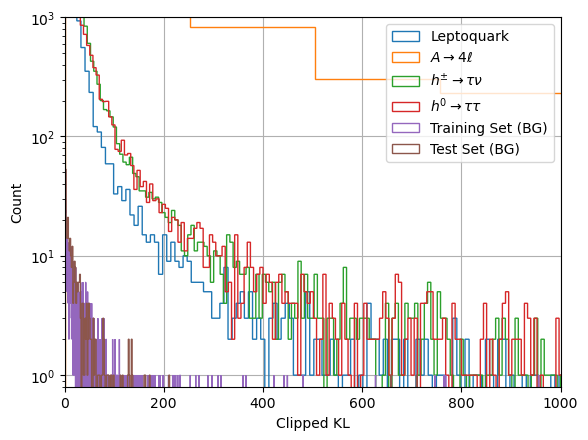

In [15]:

data = [leptoquark_data, Ato4l_data, hChToTauNu_data, hToTauTau_data
               , X_train
               , X_test
               ]
data_names_tex = [ # latex version
                "Leptoquark"
                , "$A\\rightarrow 4\ell$"
                , "$h^{\pm}\\rightarrow\\tau \\nu$"
                , "$h^0\\rightarrow\\tau\\tau$"
                , "Training Set (BG)" # Background
                , "Test Set (BG)" # Background
                ]

anomaly_scores = []
for data in data:
    s = calc_anomaly_dist(data, just_enc, AD_score_CKL)
    anomaly_scores.append(s)

for i in range(len(data_names_tex)):
    dat = anomaly_scores[i]
    bin_n = int(len(dat))
    # print(bin_n)
    plt.hist(dat
             , bins = int(bin_n/400)
             , label=data_names_tex[i] # + " " + str(bin_n)
             , histtype = "step"
            #  , density=True
             )

plt.legend(loc="upper right")
# plt.loglog()
plt.semilogy()
# plt.semilogx()
plt.xlabel("Clipped KL")
plt.ylabel("Count")
plt.grid()
plt.ylim((0.8, 1000))
plt.xlim((0, 1000))